## Visualize pileup of deletions in the vicinity of enhancers 
https://www.nxn.se/valent/visualizing-overlapping-intervals

(0.0, 6.0)

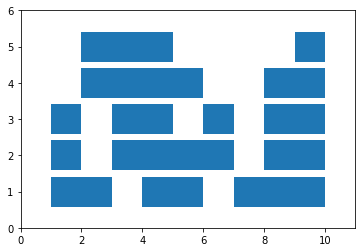

In [3]:
import matplotlib.pyplot as plt

intervals = [(2, 6), (7, 10), (1, 3), (4, 6), (8, 10), (1, 2), (3, 7), (9, 10), (1, 2), (3, 5), (6, 7), (8, 10), (2, 5), (8, 10)]

def intervals2layers(si):
    layers = [[si[0]]]
    for p in si[1:]:
        for lay in layers:
            if lay[-1][-1] < p[0]:
                lay.append(p)
                break
        else:
            layers.append([p])

    return layers

si = sorted(intervals, key=lambda p: p[0])
layers = intervals2layers(si)

for i, lay in enumerate(layers):
    x1, x2 = zip(*lay)
    plt.hlines([i + 1] * len(x1), x1, x2, lw=30)

plt.xlim(0, 11)
plt.ylim(0, 6)

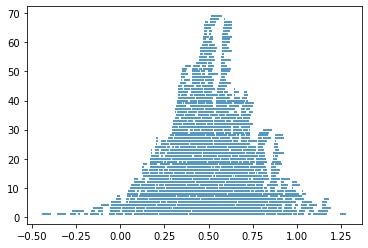

In [12]:
import random 

intervals = []
for i in range(1024):
    x1 = random.normalvariate(0.5, 0.25)
    x2 = x1 + random.random() / 16
    intervals.append((x1, x2))

si = sorted(intervals, key=lambda p: p[0])
layers = intervals2layers(si)

for i, lay in enumerate(layers):
    x1, x2 = zip(*lay)
    plt.hlines([i + 1] * len(x1), x1, x2)


## Compute per-bp coverage of deletions in the vicinity of enhancers

https://www.geeksforgeeks.org/maximum-number-of-overlapping-intervals/ 

In [14]:
# TODO 
# Generalize the code below to include a per-bp coverage variable that is updated as the intervals are traversed 

In [13]:
# Python3 program that print maximum
# number of overlap
# among given ranges

# Function that print maximum
# overlap among ranges
def overlap(v):

	# variable to store the maximum
	# count
	ans = 0
	count = 0
	data = []

	# storing the x and y
	# coordinates in data vector
	for i in range(len(v)):

		# pushing the x coordinate
		data.append([v[i][0], 'x'])

		# pushing the y coordinate
		data.append([v[i][1], 'y'])

	# sorting of ranges
	data = sorted(data)

	# Traverse the data vector to
	# count number of overlaps
	for i in range(len(data)):

		# if x occur it means a new range
		# is added so we increase count
		if (data[i][1] == 'x'):
			count += 1

		# if y occur it means a range
		# is ended so we decrease count
		if (data[i][1] == 'y'):
			count -= 1

		# updating the value of ans
		# after every traversal
		ans = max(ans, count)

	# printing the maximum value
	print(ans)

# Driver code
v = [ [ 1, 2 ], [ 2, 4 ], [ 3, 6 ] ]
overlap(v)

# This code is contributed by mohit kumar 29


2
